In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Activation, concatenate
from tensorflow.keras.callbacks import History
from tensorflow.keras import optimizers


In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

In [3]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 1)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3490,2023-01-25 00:00:00-03:00,109.000000,110.680000,108.209999,110.650002,6427546,0,0
3491,2023-01-26 00:00:00-03:00,110.699997,111.099998,109.860001,110.419998,4382206,0,0
3492,2023-01-27 00:00:00-03:00,110.279999,110.290001,108.339996,108.400002,5294651,0,0
3493,2023-01-30 00:00:00-03:00,109.010002,109.320000,108.129997,108.699997,2905618,0,0


## 4. Pre-processing

In [5]:
bova11.columns = bova11.columns.str.lower()
bova11.date = pd.to_datetime(bova11.date)

In [7]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

In [8]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [9]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3402/3402 [00:00<00:00, 5982.33it/s]


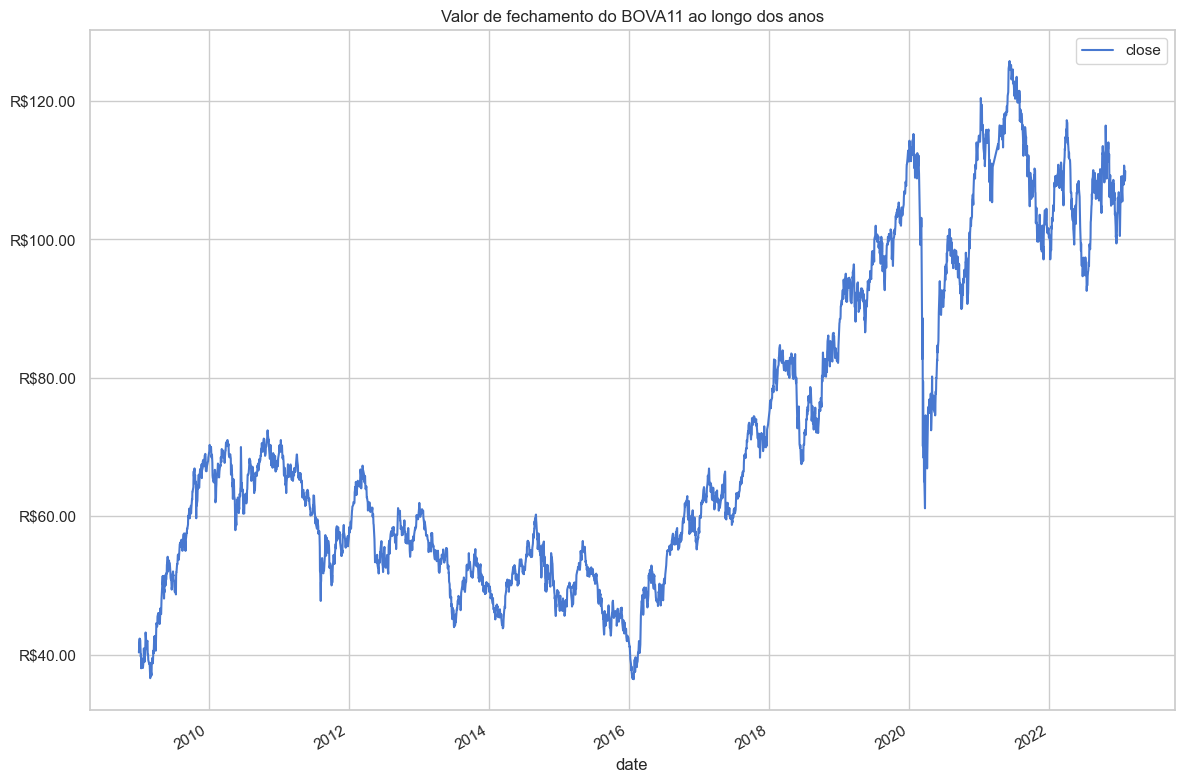

In [10]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

In [11]:
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()

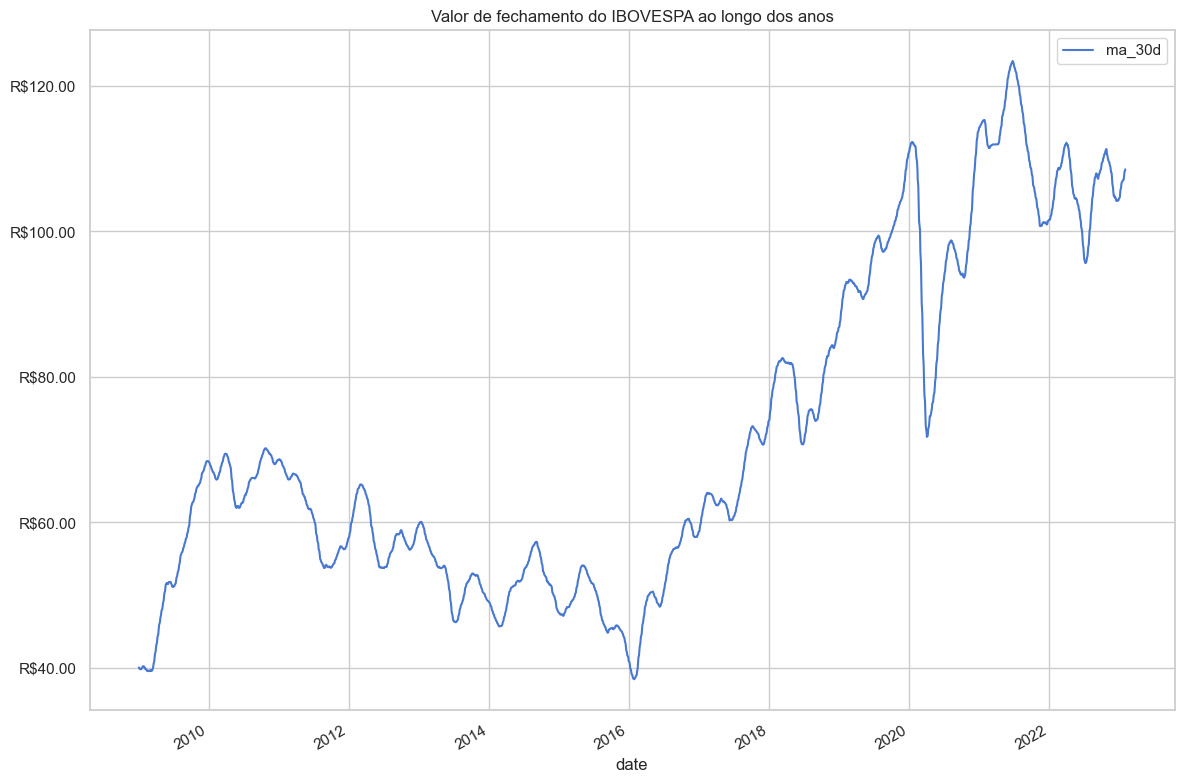

In [12]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

In [13]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [14]:
bova11['target'] = bova11.close - bova11.open
bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [15]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.39030025 -0.91719676 -0.95032594 ... -0.78570428  1.
  -0.8756999 ]
 [-0.35971966 -0.87970094 -0.91076644 ... -0.79239236  1.
  -0.86853306]
 [-0.33009474 -0.87255889 -0.86918409 ... -0.83530725  1.
  -0.90615904]
 ...
 [ 0.75647048  0.64445932  0.63205208 ... -0.89494206 -1.
   0.61814103]
 [ 0.73624277  0.62280992  0.62733194 ... -0.85119142 -1.
   0.64367293]
 [ 0.73146451  0.63709403  0.64036862 ... -0.81106316  1.
          nan]]


In [16]:
backcandles = 100
X = []
for j in range(8): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3302, 100, 8), (3302, 1))

In [17]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

In [18]:
def create_gru_model(backcandles, num_features):
    gru_input = Input(shape = (backcandles, num_features), name = 'lstm_input')
    inputs = GRU(150, name = 'first_layer')(lstm_input)
    inputs = Dense(1, name = 'dense_layer')(inputs)
    output = Activation('linear', name = 'output')(inputs)
    model = Model(inputs = lstm_input, outputs = output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [19]:
model = create_gru_model(100, 8)
model.fit(x = X_train, y = y_train, batch_size = 15, epochs = 30, shuffle = True, validation_split = 0.1)

Epoch 1/30
179/179 [==============================] - 30s 128ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2/30
179/179 [==============================] - 23s 131ms/step - loss: 7.8280e-04 - val_loss: 0.0017
Epoch 3/30
179/179 [==============================] - 28s 156ms/step - loss: 7.6308e-04 - val_loss: 0.0011
Epoch 4/30
179/179 [==============================] - 28s 155ms/step - loss: 7.2027e-04 - val_loss: 0.0011
Epoch 5/30
179/179 [==============================] - 39s 219ms/step - loss: 6.4242e-04 - val_loss: 0.0037
Epoch 6/30
179/179 [==============================] - 32s 178ms/step - loss: 6.5516e-04 - val_loss: 0.0018
Epoch 7/30
179/179 [==============================] - 29s 161ms/step - loss: 5.8020e-04 - val_loss: 0.0018
Epoch 8/30
179/179 [==============================] - 28s 156ms/step - loss: 5.6214e-04 - val_loss: 0.0011
Epoch 9/30
179/179 [==============================] - 27s 149ms/step - loss: 6.1851e-04 - val_loss: 8.7444e-04
Epoch 10/30
179/179 [================

In [20]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 6s 65ms/step
[0.60789] [0.56707722]
[0.6184243] [0.61119819]
[0.6335311] [0.5968645]
[0.640888] [0.63023511]
[0.65303046] [0.62418815]
[0.64704955] [0.65218367]
[0.6334654] [0.64613655]
[0.60085356] [0.57558797]
[0.5677854] [0.57402023]
[0.5501283] [0.50503922]


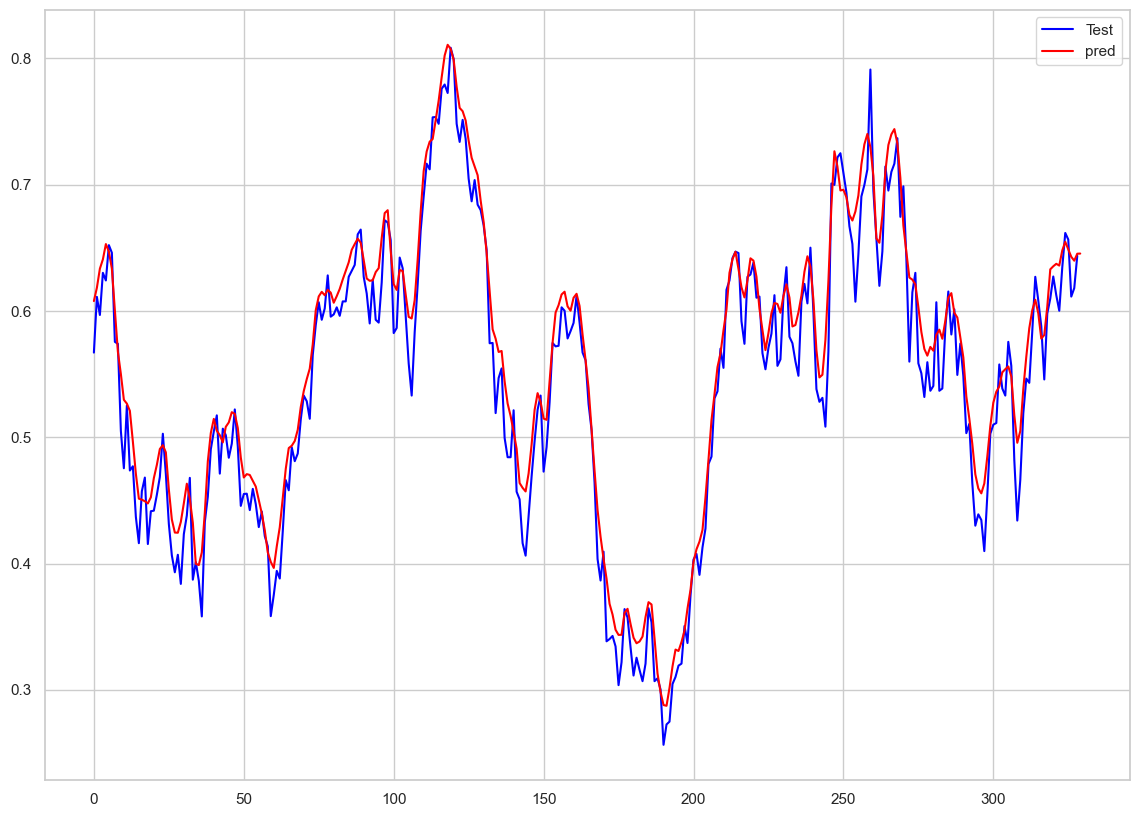

In [21]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [22]:
# removing last prediction, (nan values to calculate the right metrics)
y_test = y_test[:-1]
y_pred = y_pred[:-1]

In [23]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [24]:
MAPE(y_test, y_pred), MAE(y_test, y_pred), RMSE(y_test, y_pred)

(4.162193695043561, 0.020843004110935013, 0.025470527233047338)